# NOTEBOOK : CNN_Alexnet_cutting=10s for bulls detection

## Importations

In [2]:
import matplotlib.pyplot as plt

import torch
from torch.utils.data import dataloader
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchaudio
import torchvision.transforms as transforms



from PIL import Image

import pandas as pd

from typing import Any, Callable, Optional, Tuple

import numpy as np

import os

pd.set_option('display.max_colwidth', -1)

from datetime import datetime

import matplotlib.pyplot as plt
# Code for big plots
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## Retrieval of audios and labels

In [2]:
# Make panda dataframe with paths and labels of audio files

def getAudioFiles(path_directory):
        
        files_path = []
        files_name = []

        for path, subdirs, files in os.walk(path_directory):
            files.sort()
            for name in files :
                if name.endswith(".wav"):
                    files_path.append(path + os.path.sep + name)
        #print("-", len(files_path), "files found in the directory", path_directory,'\n')

        return files_path
    

#folder_audio = "C:/Users/thomas guerin/Documents/COURS IMT MINES ALES/Département 2IA/3A/S10/Etude technique/DATA/lgi2p-alose/tmp/bulls_audio/audio_out"
folder_audio = "/mnt/Baie-MD1400/data/guyot/dev/MRM/lgi2p-alose/tmp/bulls_audio/audio_out"



files_path = getAudioFiles(folder_audio)
number = len(files_path)

filenames = []
dic_Labels = {}
#pathOfLabels = "C:/Users/thomas guerin/Documents/COURS IMT MINES ALES/Département 2IA/3A/S10/Etude technique/DATA/lgi2p-alose/tmp/bulls_audio/audio_annotated"
pathOfLabels = "/mnt/Baie-MD1400/data/guyot/dev/MRM/lgi2p-alose/tmp/bulls_audio/audio_annotated"

for path, subdirs, files in os.walk(pathOfLabels):
    for filename in sorted(files) :
        with open(os.path.join(pathOfLabels, filename),'r') as labels_file:
            lines = labels_file.readlines()
            labels_file.close()
            for line in lines :
                split_line = line.split(' ')
                filenames.append(line)
                file = split_line[0]
                file_name, extension = os.path.splitext(file)
                dic_Labels[file_name] = split_line[1][0]
                
y = np.zeros(number)
for idx_file, file_path in enumerate(files_path):
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    y[idx_file] = int(dic_Labels[file_name])  

## Creation of dataloaders (for the use of data "on the fly")

In [3]:
class MyDataset(Dataset):
  
  def __init__(self, files, labels, transform):
    super(MyDataset,self).__init__()
    self.files = files_path
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    wave = torchaudio.load(self.files[idx])[0] # Il faudrait déterminer les paramètres de transformation
    melspectro = self.transform(wave)
    label = self.labels[idx]
    return melspectro,label

In [4]:
def return_indexes(text):
    l = []
    n = len(files_path)
    for i in range(n):
        if text in files_path[i]:
            l.append(i)
    return [l[0],l[-1]]

In [5]:
#Data for validation and test

index_ceze_2017_p1 = return_indexes(text = "2017_05_22-23_13_00")

index_ceze_2017_p2 = return_indexes(text = "2017_05_24-23_15_00")

index_ceze_2017_p3 = return_indexes(text = "2017_05_26-23_03_00")

index_ceze_2017_p4 = return_indexes(text = "2017_06_01-23_20_00")

index_ceze_2018 = return_indexes(text = "2018-06-10_22-25")

index_ardoise_2014_p1 = return_indexes(text = "2014_05_24-01_41_10")

index_ardoise_2014_p2 = return_indexes(text = "2014_05_24-23_14_00")


validation_index = list(range(index_ardoise_2014_p2[0]+869,index_ardoise_2014_p2[1]+1)) + list(range(index_ceze_2017_p1[0],index_ceze_2017_p1[1]+1)) + list(range(index_ceze_2017_p2[0],index_ceze_2017_p2[1]+1)) + list(range(index_ceze_2017_p3[0],index_ceze_2017_p3[1]+1)) 
test_index = list(range(index_ardoise_2014_p1[0],index_ardoise_2014_p1[1]+1)) + list(range(index_ardoise_2014_p2[0],index_ardoise_2014_p2[0]+869)) + list(range(index_ceze_2017_p4[0],index_ceze_2017_p4[1]+1)) + list(range(index_ceze_2018[0],index_ceze_2018[1]+1)) 

In [6]:
def audio_importation(shuffle=False):
    
    # Transforming audio files into melspectrograms
    transform = transforms.Compose([
        torchaudio.transforms.MelSpectrogram(n_fft=4096, hop_length=4096//4),
        transforms.Resize((128,431))
    ]) 
    
    df = MyDataset(files_path, y, transform)
    
    validation_indexes = validation_index
    test_indexes = test_index
    train_indexes = list( set(range(len(df))) - set(validation_indexes) - set(test_indexes) )
    

    train_set = torch.utils.data.Subset(df, train_indexes)
    validation_set = torch.utils.data.Subset(df, validation_indexes)
    test_set = torch.utils.data.Subset(df, test_indexes)
    
    trainloader = DataLoader(train_set, batch_size=16, shuffle=shuffle, num_workers=0)
    validationloader = DataLoader(validation_set, batch_size=16, shuffle=False, num_workers=0)
    testloader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=0)
    
    bulls_proportion = (list(y[:train_indexes[-1]]).count(1))/len(train_indexes)
    weight_bulls = 1 / (bulls_proportion + 1)
    weight_no_bulls = 1 / (( 1 / (bulls_proportion + 0.0001) ) + 1)
    # Those weights will be used to manage the problem of unbalanced classes ( nb(no_bulls)>>nb(bulls) )
    
    return trainloader,validationloader,testloader,weight_bulls,weight_no_bulls

### Creation of the model

In [7]:
from torchvision import models
import torch.nn.functional as F

def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

In [8]:
class model_alexnet(torch.nn.Module):
    def __init__(self, pretrained=False, freeze=False):
        super(model_alexnet, self).__init__()
        alexnet = models.alexnet(pretrained=pretrained)
        if freeze:
            alexnet = models.alexnet(pretrained=True)
            freeze_model(alexnet)
        self.batchnorm1 = torch.nn.BatchNorm2d(num_features=1, affine=False)
        self.conv1 = torch.nn.Conv2d(1, 3, (1,1), stride=(1,1), padding=0, bias=False)
        self.alexnet = alexnet
        self.drop1 = torch.nn.Dropout(0.3)
        self.lin1 = torch.nn.Linear(in_features=1000, out_features=100, bias=True)
        self.drop2 = torch.nn.Dropout(0.2)
        self.lin2 = torch.nn.Linear(in_features=100, out_features=2, bias=True)
    def forward(self, x):
        x = self.batchnorm1(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.alexnet(x))
        x = self.drop1(x)
        x = F.relu(self.lin1(x))
        x = self.drop2(x)
        x = self.lin2(x)
        return x

### Training

In [9]:
def training(model, name_model, device, epochs, learning_rate=1e-4, batch_size=128, early_stop_nb = 10):
    
    model.to(device)
    
    weight = torch.tensor([weight_no_bulls,weight_bulls])
    weight = weight.to(device)
    
    loss_fn = torch.nn.CrossEntropyLoss(reduction='mean',weight=weight)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    #bulls = torch.tensor([1 for i in range(16)])
    #no_bulls = torch.tensor([0 for i in range(16)])
    #bulls = bulls.to(device)
    #no_bulls = no_bulls.to(device)
    
    best_score = 0
    early_stop_count = 0
    
    epoch_improvement = [1]
    
    list_train_loss_cumul = []
    list_metric = []
    
    for t in range(epochs):
        
        model.train() # we specify that we are training the model
        
        # At each epoch, the training set will be processed as a set of batches
        
        # We use accumulated gradients ( ex: batch_size = 128 = 8 * (16 batches) ) to avoid memory pb
        
        accum_step = batch_size//16
        
        optimizer.zero_grad()
        
        train_loss_cumul = 0
        
        for batch_id,  batch in enumerate(trainloader) : 
            
            images, labels  = batch
            
            labels = labels.long()
            
            bulls = torch.tensor([1 for i in range(labels.shape[0])])
            no_bulls = torch.tensor([0 for i in range(labels.shape[0])])
            bulls = bulls.to(device)
            no_bulls = no_bulls.to(device)
            
            # we put the data on the same device
            images , labels = images.to(device), labels.to(device)
            
            y_pred = model(images) # forward pass output=logits
            
            loss = loss_fn(y_pred, labels)
            
            loss /= accum_step  # Because the cross entropy loss is a mean
            
            train_loss_cumul += loss.item()
            
            loss.backward()       # update the gradient (cf https://towardsdatascience.com/what-is-gradient-accumulation-in-deep-learning-ec034122cfa#:~:text=Gradient%20accumulation%20means%20running%20a,Yes%2C%20it's%20really%20that%20simple.)
            
            if ( (batch_id + 1) % accum_step == 0 ):
                
                optimizer.step() # update the model parameters using the gradient
                
                optimizer.zero_grad() # clear the gradient before backward
                
                print("epoch: {:03d}, batch: {:03d}, loss: {:.3f} ".format(t+1, (batch_id+1)//accum_step, loss.item()*accum_step))
                #print("e: {:03d}, b: {:03d}, l: {:.3f} ".format(t+1, (batch_id+1)//accum_step, loss.item()*accum_step), end='')
                
                
        # Training score
        
        model.eval()
        
        total = 0
        correct = 0
        total_real_bulls = 0
        total_real_no_bulls = 0
        total_predicted_bulls = 0
        total_predicted_no_bulls = 0
        correct_real_bulls = 0
        correct_real_no_bulls = 0
        correct_predicted_bulls = 0
        correct_predicted_no_bulls = 0
        
        for batch_id, batch in enumerate(trainloader):
           
            images , labels = batch
                        
            labels = labels.long() # float --> Long
            
            bulls = torch.tensor([1 for i in range(labels.shape[0])])
            no_bulls = torch.tensor([0 for i in range(labels.shape[0])])
            bulls = bulls.to(device)
            no_bulls = no_bulls.to(device)
              
            images , labels = images.to(device), labels.to(device)
            
            y_pred = model(images) # forward computes the logits
            
            sf_y_pred = torch.nn.Softmax(dim=1)(y_pred) # softmax to obtain the probability distribution
            
            _, predicted = torch.max(sf_y_pred , 1)     # decision rule, we select the max
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_real_bulls += (labels == bulls).sum().item()
            total_real_no_bulls += (labels == no_bulls).sum().item()
            total_predicted_bulls += (predicted == bulls).sum().item()
            total_predicted_no_bulls += (predicted == no_bulls).sum().item()
            correct_real_bulls += ( (predicted == labels) & (labels == bulls) ).sum().item()
            correct_real_no_bulls += ( (predicted == labels) & (labels == no_bulls) ).sum().item()
            correct_predicted_bulls += ( (predicted == labels) & (predicted == bulls) ).sum().item()
            correct_predicted_no_bulls += ( (predicted == labels) & (predicted == no_bulls) ).sum().item()
            
        accuracy = correct / total
            
        bulls_recall = correct_real_bulls / (total_real_bulls + 0.01)
        bulls_precision = correct_predicted_bulls / (total_predicted_bulls + 0.01)
            
        no_bulls_recall = correct_real_no_bulls / (total_real_no_bulls + 0.01)
        no_bulls_precision = correct_predicted_no_bulls / (total_predicted_no_bulls + 0.01)
        
        list_train_loss_cumul.append(train_loss_cumul)
            
        print("epoch: {:03d} ------------------------------------------------".format(t+1)+ "\n")
        print("[train] loss: {:.3f}\n".format(train_loss_cumul))
        print("\n" + "[train] accuracy: {:.3f}%\n".format(100*accuracy) )
        print("[train] bulls_recall: {:.3f}%\n".format(100*bulls_recall))
        print("[train] bulls_precision: {:.3f}%\n".format(100*bulls_precision) )
        print("[train] no_bulls_recall: {:.3f}%\n".format(100*no_bulls_recall))
        print("[train] no_bulls_precision: {:.3f}%\n".format(100*no_bulls_precision) )
        
        
        # Validation score
        
        model.eval()
        
        total = 0
        correct = 0
        total_real_bulls = 0
        total_real_no_bulls = 0
        total_predicted_bulls = 0
        total_predicted_no_bulls = 0
        correct_real_bulls = 0
        correct_real_no_bulls = 0
        correct_predicted_bulls = 0
        correct_predicted_no_bulls = 0
        
        for batch_id, batch in enumerate(validationloader):
            
            images , labels = batch
            
            labels = labels.long() # float --> Long
            
            bulls = torch.tensor([1 for i in range(labels.shape[0])])
            no_bulls = torch.tensor([0 for i in range(labels.shape[0])])
            bulls = bulls.to(device)
            no_bulls = no_bulls.to(device)
            
            images , labels = images.to(device), labels.to(device)
            
            y_pred = model(images) # forward computes the logits
            sf_y_pred = torch.nn.Softmax(dim=1)(y_pred) # softmax to obtain the probability distribution
            _, predicted = torch.max(sf_y_pred , 1)     # decision rule, we select the max
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_real_bulls += (labels == bulls).sum().item()
            total_real_no_bulls += (labels == no_bulls).sum().item()
            total_predicted_bulls += (predicted == bulls).sum().item()
            total_predicted_no_bulls += (predicted == no_bulls).sum().item()
            correct_real_bulls += ( (predicted == labels) & (labels == bulls) ).sum().item()
            correct_real_no_bulls += ( (predicted == labels) & (labels == no_bulls) ).sum().item()
            correct_predicted_bulls += ( (predicted == labels) & (predicted == bulls) ).sum().item()
            correct_predicted_no_bulls += ( (predicted == labels) & (predicted == no_bulls) ).sum().item()
            
        accuracy = correct / total
            
        bulls_recall = correct_real_bulls / (total_real_bulls + 0.01)
        bulls_precision = correct_predicted_bulls / (total_predicted_bulls + 0.01)
            
        no_bulls_recall = correct_real_no_bulls / (total_real_no_bulls + 0.01)
        no_bulls_precision = correct_predicted_no_bulls / (total_predicted_no_bulls + 0.01)
        
        metric = (bulls_recall + no_bulls_recall)/2
        
        list_metric.append(metric)
            
        print("[validation] accuracy: {:.3f}%\n".format(100*accuracy))
        print("[validation] bulls_recall: {:.3f}%\n".format(100*bulls_recall))
        print("[validation] bulls_precision: {:.3f}%\n".format(100*bulls_precision))
        print("[validation] no_bulls_recall: {:.3f}%\n".format(100*no_bulls_recall))
        print("[validation] no_bulls_precision: {:.3f}%\n".format(100*no_bulls_precision))
        print("[validation] scoring metric (average recall): " + str(metric) + "\n")
        
        
        # Early Stopping
        
        val_score = metric
        
        if val_score >= best_score:
            best_score = val_score
            early_stop_count = 0
            path = name_model + "__epoch" + str(epoch_improvement[-1]) + ".pth"
            if os.path.exists(path):
                os.remove(path)
            epoch_improvement.append(t+1)
            new_path = name_model + "__epoch" + str(epoch_improvement[-1]) + ".pth"
            torch.save(model, new_path)
        else:
            early_stop_count += 1
        if early_stop_count == early_stop_nb:
            break
        
    print("\n" + "Final nb epochs : " + str(epoch_improvement[-1]))
    print("Best validation score (= best bulls_fscore) : " + str(best_score))
    
    
    # We plot graphs for training and validation errors
    
    num_epochs = list(range(1,t+2))
    
    plt.xlabel("epochs")
    plt.ylabel("training loss")
    plt.plot(num_epochs, list_train_loss_cumul)
    plt.show()
    
    plt.xlabel("epochs")
    plt.ylabel("metric (on validation dataset)")
    plt.plot(num_epochs, list_metric)
    plt.show()
    
    
    # We return the best model
    
    model = torch.load(new_path)
    
    return model

### Test

In [10]:
def test(model):
    
    model.eval()
    
    total = 0
    correct = 0
    total_real_bulls = 0
    total_real_no_bulls = 0
    total_predicted_bulls = 0
    total_predicted_no_bulls = 0
    correct_bulls = 0
    correct_no_bulls = 0
    
    for batch_id, batch in enumerate(testloader):
        
        images , labels = batch
        
        bulls = torch.tensor([1 for i in range(labels.shape[0])])
        no_bulls = torch.tensor([0 for i in range(labels.shape[0])])
        
        bulls = bulls.to(device)
        no_bulls = no_bulls.to(device)
        
        labels = labels.long() # float --> Long
        
        images , labels = images.to(device), labels.to(device)
        
        y_pred = model(images) # forward computes the logits
        sf_y_pred = torch.nn.Softmax(dim=1)(y_pred) # softmax to obtain the probability distribution
        _, predicted = torch.max(sf_y_pred , 1)     # decision rule, we select the max
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_real_bulls += (labels == bulls).sum().item()
        total_real_no_bulls += (labels == no_bulls).sum().item()
        total_predicted_bulls += (predicted == bulls).sum().item()
        total_predicted_no_bulls += (predicted == no_bulls).sum().item()
        correct_bulls += ( (predicted == labels) & (labels == bulls) ).sum().item()
        correct_no_bulls += ( (predicted == labels) & (labels == no_bulls) ).sum().item()
    
    accuracy = correct / total
    
    bulls_recall = correct_bulls / (total_real_bulls + 0.01)
    bulls_precision = correct_bulls / (total_predicted_bulls + 0.01)
    
    no_bulls_recall = correct_no_bulls / (total_real_no_bulls + 0.01)
    no_bulls_precision = correct_no_bulls / (total_predicted_no_bulls + 0.01)
    
    metric = (bulls_recall + no_bulls_recall)/2
    
    print("Confusion matrix (rows : real (no_bulls and bulls)  ;  columns : predicted (same) ): ")
    print(str(correct_bulls) + "  |  " + str(total_real_bulls - correct_bulls))
    print(str(total_real_no_bulls - correct_no_bulls) + "  |  " + str(correct_no_bulls) + "\n")
    print("[test] accuracy: {:.3f}%\n".format(100*accuracy) + "\n")
    print("[test] bulls_recall: {:.3f}%\n".format(100*bulls_recall))
    print("[test] bulls_precision: {:.3f}%\n".format(100*bulls_precision) + "\n")
    print("[test] no_bulls_recall: {:.3f}%\n".format(100*no_bulls_recall))
    print("[test] no_bulls_precision: {:.3f}%\n".format(100*no_bulls_precision) + "\n")
    print("[test] scoring metric (average recall): " + str(metric))

### Processing

/home/guyot/miniconda3/envs/my_env/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/guyot/miniconda3/envs/my_env/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


epoch: 001, batch: 001, loss: 0.786 
epoch: 001, batch: 002, loss: 0.795 
epoch: 001, batch: 003, loss: 0.707 
epoch: 001, batch: 004, loss: 0.225 
epoch: 001, batch: 005, loss: 0.223 
epoch: 001, batch: 006, loss: 1.485 
epoch: 001, batch: 007, loss: 1.081 
epoch: 001, batch: 008, loss: 1.102 
epoch: 001, batch: 009, loss: 0.301 
epoch: 001, batch: 010, loss: 0.821 
epoch: 001, batch: 011, loss: 0.304 
epoch: 001, batch: 012, loss: 0.284 
epoch: 001, batch: 013, loss: 0.624 
epoch: 001, batch: 014, loss: 0.676 
epoch: 001, batch: 015, loss: 0.249 
epoch: 001, batch: 016, loss: 0.304 
epoch: 001, batch: 017, loss: 0.253 
epoch: 001, batch: 018, loss: 0.552 
epoch: 001, batch: 019, loss: 1.177 
epoch: 001, batch: 020, loss: 0.766 
epoch: 001, batch: 021, loss: 0.330 
epoch: 001, batch: 022, loss: 0.876 
epoch: 001, batch: 023, loss: 0.143 
epoch: 001, batch: 024, loss: 0.252 
epoch: 001, batch: 025, loss: 0.203 
epoch: 001, batch: 026, loss: 0.829 
epoch: 001, batch: 027, loss: 0.074 
e

epoch: 002, batch: 083, loss: 0.375 
epoch: 002, batch: 084, loss: 0.676 
epoch: 002, batch: 085, loss: 0.150 
epoch: 002, batch: 086, loss: 2.842 
epoch: 002, batch: 087, loss: 0.347 
epoch: 002, batch: 088, loss: 0.483 
epoch: 002, batch: 089, loss: 0.346 
epoch: 002, batch: 090, loss: 0.070 
epoch: 002, batch: 091, loss: 0.312 
epoch: 002, batch: 092, loss: 0.233 
epoch: 002, batch: 093, loss: 0.277 
epoch: 002, batch: 094, loss: 0.344 
epoch: 002, batch: 095, loss: 0.712 
epoch: 002, batch: 096, loss: 0.744 
epoch: 002, batch: 097, loss: 0.995 
epoch: 002, batch: 098, loss: 0.345 
epoch: 002, batch: 099, loss: 0.894 
epoch: 002, batch: 100, loss: 0.375 
epoch: 002, batch: 101, loss: 0.478 
epoch: 002, batch: 102, loss: 0.171 
epoch: 002, batch: 103, loss: 0.394 
epoch: 002, batch: 104, loss: 0.294 
epoch: 002, batch: 105, loss: 0.205 
epoch: 002, batch: 106, loss: 0.720 
epoch: 002, batch: 107, loss: 0.716 
epoch: 002, batch: 108, loss: 0.242 
epoch: 002, batch: 109, loss: 0.276 
e

epoch: 004, batch: 026, loss: 0.238 
epoch: 004, batch: 027, loss: 0.151 
epoch: 004, batch: 028, loss: 0.176 
epoch: 004, batch: 029, loss: 0.162 
epoch: 004, batch: 030, loss: 0.822 
epoch: 004, batch: 031, loss: 1.238 
epoch: 004, batch: 032, loss: 0.152 
epoch: 004, batch: 033, loss: 0.553 
epoch: 004, batch: 034, loss: 0.662 
epoch: 004, batch: 035, loss: 0.088 
epoch: 004, batch: 036, loss: 0.419 
epoch: 004, batch: 037, loss: 0.265 
epoch: 004, batch: 038, loss: 0.088 
epoch: 004, batch: 039, loss: 0.198 
epoch: 004, batch: 040, loss: 0.204 
epoch: 004, batch: 041, loss: 0.893 
epoch: 004, batch: 042, loss: 0.294 
epoch: 004, batch: 043, loss: 0.830 
epoch: 004, batch: 044, loss: 0.171 
epoch: 004, batch: 045, loss: 0.846 
epoch: 004, batch: 046, loss: 0.245 
epoch: 004, batch: 047, loss: 0.453 
epoch: 004, batch: 048, loss: 0.668 
epoch: 004, batch: 049, loss: 0.195 
epoch: 004, batch: 050, loss: 0.300 
epoch: 004, batch: 051, loss: 0.490 
epoch: 004, batch: 052, loss: 0.259 
e

epoch: 005, batch: 108, loss: 0.118 
epoch: 005, batch: 109, loss: 0.428 
epoch: 005, batch: 110, loss: 0.205 
epoch: 005, batch: 111, loss: 0.399 
epoch: 005, batch: 112, loss: 0.255 
epoch: 005, batch: 113, loss: 0.110 
epoch: 005, batch: 114, loss: 0.266 
epoch: 005, batch: 115, loss: 0.478 
epoch: 005, batch: 116, loss: 0.295 
epoch: 005, batch: 117, loss: 0.550 
epoch: 005, batch: 118, loss: 0.389 
epoch: 005, batch: 119, loss: 0.488 
epoch: 005, batch: 120, loss: 0.847 
epoch: 005, batch: 121, loss: 0.140 
epoch: 005, batch: 122, loss: 0.057 
epoch: 005, batch: 123, loss: 0.176 
epoch: 005, batch: 124, loss: 0.224 
epoch: 005, batch: 125, loss: 0.569 
epoch: 005, batch: 126, loss: 0.009 
epoch: 005 ------------------------------------------------

[train] loss: 49.067


[train] accuracy: 94.184%

[train] bulls_recall: 44.266%

[train] bulls_precision: 42.434%

[train] no_bulls_recall: 96.824%

[train] no_bulls_precision: 97.045%

[validation] accuracy: 72.646%

[validation] bulls

epoch: 007, batch: 051, loss: 0.903 
epoch: 007, batch: 052, loss: 0.146 
epoch: 007, batch: 053, loss: 0.815 
epoch: 007, batch: 054, loss: 0.291 
epoch: 007, batch: 055, loss: 0.279 
epoch: 007, batch: 056, loss: 0.082 
epoch: 007, batch: 057, loss: 0.043 
epoch: 007, batch: 058, loss: 0.075 
epoch: 007, batch: 059, loss: 0.686 
epoch: 007, batch: 060, loss: 0.102 
epoch: 007, batch: 061, loss: 0.323 
epoch: 007, batch: 062, loss: 0.868 
epoch: 007, batch: 063, loss: 0.715 
epoch: 007, batch: 064, loss: 0.268 
epoch: 007, batch: 065, loss: 0.995 
epoch: 007, batch: 066, loss: 0.361 
epoch: 007, batch: 067, loss: 0.127 
epoch: 007, batch: 068, loss: 0.320 
epoch: 007, batch: 069, loss: 0.281 
epoch: 007, batch: 070, loss: 0.213 
epoch: 007, batch: 071, loss: 0.287 
epoch: 007, batch: 072, loss: 0.680 
epoch: 007, batch: 073, loss: 0.949 
epoch: 007, batch: 074, loss: 0.051 
epoch: 007, batch: 075, loss: 0.202 
epoch: 007, batch: 076, loss: 3.004 
epoch: 007, batch: 077, loss: 0.300 
e

[validation] accuracy: 80.952%

[validation] bulls_recall: 85.068%

[validation] bulls_precision: 11.562%

[validation] no_bulls_recall: 80.831%

[validation] no_bulls_precision: 99.459%

[validation] scoring metric (average recall): 0.8294952632756277

epoch: 009, batch: 001, loss: 1.358 
epoch: 009, batch: 002, loss: 0.482 
epoch: 009, batch: 003, loss: 0.118 
epoch: 009, batch: 004, loss: 0.184 
epoch: 009, batch: 005, loss: 0.187 
epoch: 009, batch: 006, loss: 0.258 
epoch: 009, batch: 007, loss: 0.112 
epoch: 009, batch: 008, loss: 0.221 
epoch: 009, batch: 009, loss: 0.110 
epoch: 009, batch: 010, loss: 0.186 
epoch: 009, batch: 011, loss: 0.185 
epoch: 009, batch: 012, loss: 0.294 
epoch: 009, batch: 013, loss: 0.182 
epoch: 009, batch: 014, loss: 0.043 
epoch: 009, batch: 015, loss: 0.910 
epoch: 009, batch: 016, loss: 0.834 
epoch: 009, batch: 017, loss: 0.339 
epoch: 009, batch: 018, loss: 0.096 
epoch: 009, batch: 019, loss: 0.174 
epoch: 009, batch: 020, loss: 0.241 
epoch:

epoch: 010, batch: 077, loss: 0.029 
epoch: 010, batch: 078, loss: 0.259 
epoch: 010, batch: 079, loss: 0.153 
epoch: 010, batch: 080, loss: 0.236 
epoch: 010, batch: 081, loss: 0.038 
epoch: 010, batch: 082, loss: 1.222 
epoch: 010, batch: 083, loss: 0.130 
epoch: 010, batch: 084, loss: 0.224 
epoch: 010, batch: 085, loss: 0.625 
epoch: 010, batch: 086, loss: 0.318 
epoch: 010, batch: 087, loss: 0.410 
epoch: 010, batch: 088, loss: 0.318 
epoch: 010, batch: 089, loss: 1.180 
epoch: 010, batch: 090, loss: 0.257 
epoch: 010, batch: 091, loss: 0.236 
epoch: 010, batch: 092, loss: 0.173 
epoch: 010, batch: 093, loss: 0.162 
epoch: 010, batch: 094, loss: 1.250 
epoch: 010, batch: 095, loss: 0.220 
epoch: 010, batch: 096, loss: 0.717 
epoch: 010, batch: 097, loss: 0.045 
epoch: 010, batch: 098, loss: 1.203 
epoch: 010, batch: 099, loss: 0.269 
epoch: 010, batch: 100, loss: 0.191 
epoch: 010, batch: 101, loss: 0.149 
epoch: 010, batch: 102, loss: 0.078 
epoch: 010, batch: 103, loss: 0.553 
e

epoch: 012, batch: 020, loss: 1.526 
epoch: 012, batch: 021, loss: 0.377 
epoch: 012, batch: 022, loss: 0.192 
epoch: 012, batch: 023, loss: 0.087 
epoch: 012, batch: 024, loss: 0.082 
epoch: 012, batch: 025, loss: 0.088 
epoch: 012, batch: 026, loss: 0.171 
epoch: 012, batch: 027, loss: 0.657 
epoch: 012, batch: 028, loss: 0.096 
epoch: 012, batch: 029, loss: 0.055 
epoch: 012, batch: 030, loss: 0.451 
epoch: 012, batch: 031, loss: 1.009 
epoch: 012, batch: 032, loss: 0.273 
epoch: 012, batch: 033, loss: 0.383 
epoch: 012, batch: 034, loss: 0.333 
epoch: 012, batch: 035, loss: 0.237 
epoch: 012, batch: 036, loss: 0.375 
epoch: 012, batch: 037, loss: 0.686 
epoch: 012, batch: 038, loss: 0.088 
epoch: 012, batch: 039, loss: 0.069 
epoch: 012, batch: 040, loss: 0.038 
epoch: 012, batch: 041, loss: 0.096 
epoch: 012, batch: 042, loss: 0.087 
epoch: 012, batch: 043, loss: 0.368 
epoch: 012, batch: 044, loss: 0.164 
epoch: 012, batch: 045, loss: 0.669 
epoch: 012, batch: 046, loss: 1.166 
e

epoch: 013, batch: 102, loss: 0.805 
epoch: 013, batch: 103, loss: 0.301 
epoch: 013, batch: 104, loss: 0.062 
epoch: 013, batch: 105, loss: 0.142 
epoch: 013, batch: 106, loss: 3.803 
epoch: 013, batch: 107, loss: 0.176 
epoch: 013, batch: 108, loss: 0.098 
epoch: 013, batch: 109, loss: 0.399 
epoch: 013, batch: 110, loss: 0.153 
epoch: 013, batch: 111, loss: 0.760 
epoch: 013, batch: 112, loss: 0.325 
epoch: 013, batch: 113, loss: 0.271 
epoch: 013, batch: 114, loss: 0.309 
epoch: 013, batch: 115, loss: 0.207 
epoch: 013, batch: 116, loss: 1.079 
epoch: 013, batch: 117, loss: 0.556 
epoch: 013, batch: 118, loss: 0.107 
epoch: 013, batch: 119, loss: 0.125 
epoch: 013, batch: 120, loss: 0.088 
epoch: 013, batch: 121, loss: 0.064 
epoch: 013, batch: 122, loss: 0.811 
epoch: 013, batch: 123, loss: 0.080 
epoch: 013, batch: 124, loss: 0.150 
epoch: 013, batch: 125, loss: 0.523 
epoch: 013, batch: 126, loss: 0.064 
epoch: 013 ------------------------------------------------

[train] loss: 

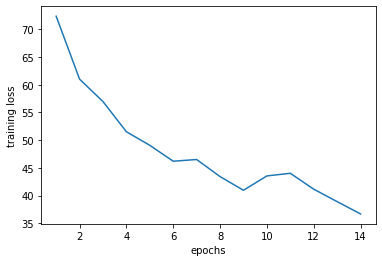

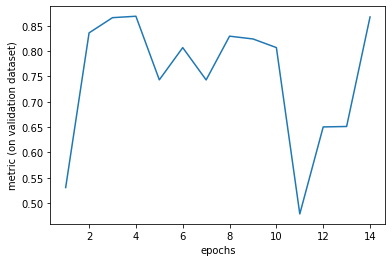

Confusion matrix (rows : real (no_bulls and bulls)  ;  columns : predicted (same) ): 
123  |  20
563  |  3880

[test] accuracy: 87.287%


[test] bulls_recall: 86.008%

[test] bulls_precision: 17.930%


[test] no_bulls_recall: 87.328%

[test] no_bulls_precision: 99.487%


[test] scoring metric (average recall): 0.8666807832114536


In [11]:
model = model_alexnet(pretrained=True, freeze=False)
name_model = "model_alexnet_pretrained_batchsize128_update4"
batch_size = 128
trainloader, validationloader, testloader, weight_bulls, weight_no_bulls = audio_importation(shuffle=True)
epochs = 80
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

final_model = training(model=model, name_model=name_model, epochs=epochs, batch_size=batch_size, device=device)

test(model=final_model)

epoch: 001, batch: 001, loss: 0.672 
epoch: 001, batch: 002, loss: 0.479 
epoch: 001, batch: 003, loss: 0.292 
epoch: 001, batch: 004, loss: 0.336 
epoch: 001, batch: 005, loss: 0.492 
epoch: 001, batch: 006, loss: 0.422 
epoch: 001, batch: 007, loss: 0.734 
epoch: 001, batch: 008, loss: 0.477 
epoch: 001, batch: 009, loss: 0.461 
epoch: 001, batch: 010, loss: 0.402 
epoch: 001, batch: 011, loss: 0.361 
epoch: 001, batch: 012, loss: 0.426 
epoch: 001, batch: 013, loss: 0.285 
epoch: 001, batch: 014, loss: 0.376 
epoch: 001, batch: 015, loss: 0.313 
epoch: 001 ------------------------------------------------

[train] loss: 9.561


[train] accuracy: 94.165%

[train] bulls_recall: 15.536%

[train] bulls_precision: 32.897%

[train] no_bulls_recall: 98.324%

[train] no_bulls_precision: 95.654%

[validation] accuracy: 91.053%

[validation] bulls_recall: 9.701%

[validation] bulls_precision: 4.180%

[validation] no_bulls_recall: 93.449%

[validation] no_bulls_precision: 97.232%

[validation] 

epoch: 009, batch: 001, loss: 0.496 
epoch: 009, batch: 002, loss: 0.177 
epoch: 009, batch: 003, loss: 0.387 
epoch: 009, batch: 004, loss: 0.296 
epoch: 009, batch: 005, loss: 0.796 
epoch: 009, batch: 006, loss: 0.450 
epoch: 009, batch: 007, loss: 0.874 
epoch: 009, batch: 008, loss: 0.227 
epoch: 009, batch: 009, loss: 0.377 
epoch: 009, batch: 010, loss: 0.343 
epoch: 009, batch: 011, loss: 0.153 
epoch: 009, batch: 012, loss: 0.233 
epoch: 009, batch: 013, loss: 0.299 
epoch: 009, batch: 014, loss: 0.081 
epoch: 009, batch: 015, loss: 0.076 
epoch: 009 ------------------------------------------------

[train] loss: 6.393


[train] accuracy: 94.363%

[train] bulls_recall: 31.442%

[train] bulls_precision: 41.871%

[train] no_bulls_recall: 97.691%

[train] no_bulls_precision: 96.421%

[validation] accuracy: 31.476%

[validation] bulls_recall: 49.250%

[validation] bulls_precision: 2.058%

[validation] no_bulls_recall: 30.952%

[validation] no_bulls_precision: 95.392%

[validation]

epoch: 017, batch: 001, loss: 0.410 
epoch: 017, batch: 002, loss: 0.146 
epoch: 017, batch: 003, loss: 0.953 
epoch: 017, batch: 004, loss: 0.096 
epoch: 017, batch: 005, loss: 0.128 
epoch: 017, batch: 006, loss: 0.443 
epoch: 017, batch: 007, loss: 0.290 
epoch: 017, batch: 008, loss: 0.657 
epoch: 017, batch: 009, loss: 0.497 
epoch: 017, batch: 010, loss: 0.375 
epoch: 017, batch: 011, loss: 0.150 
epoch: 017, batch: 012, loss: 0.079 
epoch: 017, batch: 013, loss: 0.561 
epoch: 017, batch: 014, loss: 0.745 
epoch: 017, batch: 015, loss: 0.311 
epoch: 017 ------------------------------------------------

[train] loss: 5.901


[train] accuracy: 95.032%

[train] bulls_recall: 28.236%

[train] bulls_precision: 51.001%

[train] no_bulls_recall: 98.565%

[train] no_bulls_precision: 96.292%

[validation] accuracy: 41.384%

[validation] bulls_recall: 42.534%

[validation] bulls_precision: 2.092%

[validation] no_bulls_recall: 41.350%

[validation] no_bulls_precision: 96.067%

[validation]

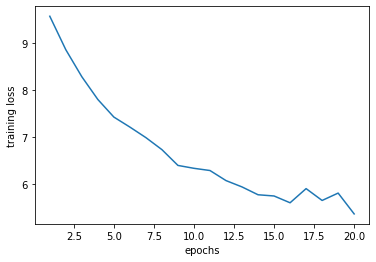

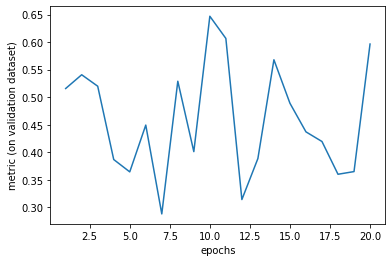

Confusion matrix (rows : real (no_bulls and bulls)  ;  columns : predicted (same) ): 
88  |  55
589  |  3854

[test] accuracy: 85.957%


[test] bulls_recall: 61.534%

[test] bulls_precision: 12.998%


[test] no_bulls_recall: 86.743%

[test] no_bulls_precision: 98.593%


[test] scoring metric (average recall): 0.7413857737625724


In [12]:
model = model_alexnet(pretrained=True, freeze=False)
name_model = "model_alexnet_pretrained_batchsize1024_update4"
batch_size = 1024
trainloader, validationloader, testloader, weight_bulls, weight_no_bulls = audio_importation(shuffle=True)
epochs = 80
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

final_model = training(model=model, name_model=name_model, epochs=epochs, batch_size=batch_size, device=device)

test(model=final_model)